# Overview
Steps to build the network:

1. Load the training data and do a train/validation split.
2. Preprocess data.
3. Build a convolutional neural network to classify traffic signs.
4. Build a feedforward neural network to classify traffic signs.
5. Evaluate performance of final neural network on testing data.

Keep an eye on the network’s accuracy over time. Once the accuracy reaches the 98% range, you can be confident that you’ve built and trained an effective model.

In [184]:
import pandas as pd
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
import math

from keras.models import Sequential
from keras.layers import Dense, Activation

import json

Load the Data

In [195]:
# Load the data by reading the logfile

data = pd.read_csv('data/data/driving_log.csv',dtype={'center': str, 'left':str,'right':str,'steering': np.float32,'throttle': np.float32,'brake': np.float32,'speed': np.float32})
                   #converters={'category',"Price":int} dtype='category')
print(data.dtypes)

X_train = data['center']
y_train = data['steering']

print('Training data size = ', len(X_train))
print('Training labels size = ',len(y_train))
print('Data loaded')

center       object
left         object
right        object
steering    float32
throttle    float32
brake       float32
speed       float32
dtype: object
Training data size =  8036
Training labels size =  8036
Data loaded


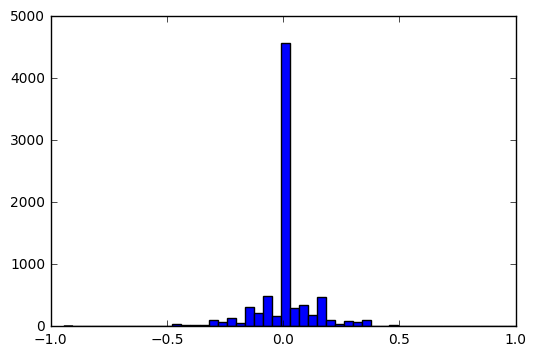

In [196]:
# examine the data
import matplotlib.pyplot as plt
plt.hist(y_train,50)
plt.show()

In [197]:
# there are a lot of images corresponding to the zero value
# we can remove most of them
# 1) copy those values to the zero_values array
# 2) copy the non zero values to the train_crop array
# 3) add just a few random zero values to the final array
X_zero_values_array = []
y_zero_values_array = []
X_train_crop = []
y_train_crop = []
for i in range(len(X_train)):
    if y_train[i] == 0:
        X_zero_values_array.append(X_train[i])
        y_zero_values_array.append(y_train[i])
    else:
        X_train_crop.append(X_train[i])
        y_train_crop.append(y_train[i])
print('Removed all values with steering = 0.0')

Removed all values with steering = 0.0


In [198]:
def print_num_el():
    print ('Number of elements remaining:',len(X_train_crop))
    print ('Number of elements remaining:',len(y_train_crop))
    print ('Number of elements removed:',len(X_zero_values_array))
    print ('Number of elements removed:',len(y_zero_values_array))
print_num_el()

Number of elements remaining: 3675
Number of elements remaining: 3675
Number of elements removed: 4361
Number of elements removed: 4361


Higher steering values are very scarce so we need to augment the density of those values in our training set.
In order to do so without interfering with the data directly (e.g. by introducing shifts and artificial rotations, flips, etc) we will just add more of those elements with higher steering by duplicating them.

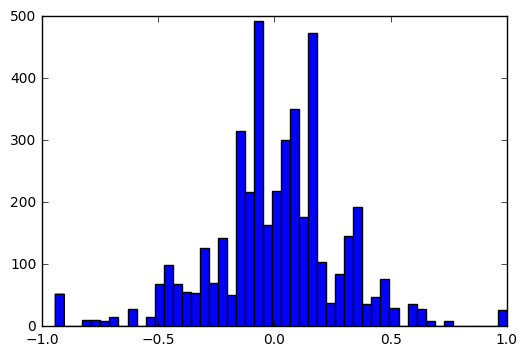

In [199]:
X_train_aug = list(X_train_crop)
y_train_aug = list(y_train_crop)
for i in range(len(y_train_crop)):
#   if abs(y_train_crop[i]) > 0.1:
#        X_train_aug.append(X_train_crop[i])
#        y_train_aug.append(y_train_crop[i])
#    if abs(y_train_crop[i]) > 0.2:
#        X_train_aug.append(X_train_crop[i])
#        y_train_aug.append(y_train_crop[i])
    if abs(y_train_crop[i]) > 0.3:
        X_train_aug.append(X_train_crop[i])
        y_train_aug.append(y_train_crop[i])
    if abs(y_train_crop[i]) > 0.4:
        X_train_aug.append(X_train_crop[i])
        y_train_aug.append(y_train_crop[i])
    if abs(y_train_crop[i]) > 0.45:
        X_train_aug.append(X_train_crop[i])
        y_train_aug.append(y_train_crop[i])
    if abs(y_train_crop[i]) > 0.5:
        X_train_aug.append(X_train_crop[i])
        y_train_aug.append(y_train_crop[i])
    if abs(y_train_crop[i]) > 0.55:
        X_train_aug.append(X_train_crop[i])
        y_train_aug.append(y_train_crop[i])
    if abs(y_train_crop[i]) > 0.6:
        X_train_aug.append(X_train_crop[i])
        y_train_aug.append(y_train_crop[i])
    if abs(y_train_crop[i]) > 0.65:
        X_train_aug.append(X_train_crop[i])
        y_train_aug.append(y_train_crop[i])
    if abs(y_train_crop[i]) > 0.7:
        X_train_aug.append(X_train_crop[i])
        y_train_aug.append(y_train_crop[i])
    if abs(y_train_crop[i]) > 0.75:
        X_train_aug.append(X_train_crop[i])
        y_train_aug.append(y_train_crop[i])
    if abs(y_train_crop[i]) > 0.8:
        X_train_aug.append(X_train_crop[i])
        y_train_aug.append(y_train_crop[i])
    if abs(y_train_crop[i]) > 0.85:
        X_train_aug.append(X_train_crop[i])
        y_train_aug.append(y_train_crop[i])
    if abs(y_train_crop[i]) > 0.9:
        X_train_aug.append(X_train_crop[i])
        y_train_aug.append(y_train_crop[i])
    
plt.hist(y_train_aug, 50)
plt.show()


In [200]:
# there are still a lot of images between -0.3 and 0.3
# we can remove most of them
# 1) copy those values to the zero_values array
# 2) copy the non zero values to the train_crop array
# 3) add just a few random zero values to the final array
X_zero_values_array2 = []
y_zero_values_array2 = []
X_train_crop2 = []
y_train_crop2 = []
for i in range(len(X_train_crop)):
    if y_train_crop[i] > -0.3 and y_train_crop[i] < 0.3:
        X_zero_values_array2.append(X_train_crop[i])
        y_zero_values_array2.append(y_train_crop[i])
    else:
        X_train_crop2.append(X_train_crop[i])
        y_train_crop2.append(y_train_crop[i])
print('Removed all values with steering between -0.5 and 0.5')

Removed all values with steering between -0.5 and 0.5


In [201]:
#add some random values back to the X_train_crop2
import random
num_to_add = 100
random.shuffle(X_zero_values_array2)
for i in range(num_to_add):
    X_train_crop2.append(X_zero_values_array2[i])
    y_train_crop2.append(y_zero_values_array2[i])
print('Added back some values with steering between -0.5 and 0.5')
print_num_el()

Added back some values with steering between -0.5 and 0.5
Number of elements remaining: 3675
Number of elements remaining: 3675
Number of elements removed: 4361
Number of elements removed: 4361


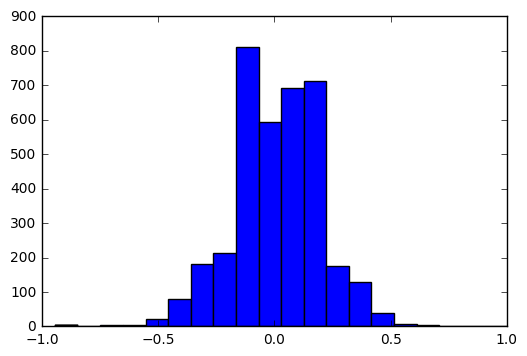

In [202]:
# examine data again
plt.hist(y_train_crop,20)
plt.show()

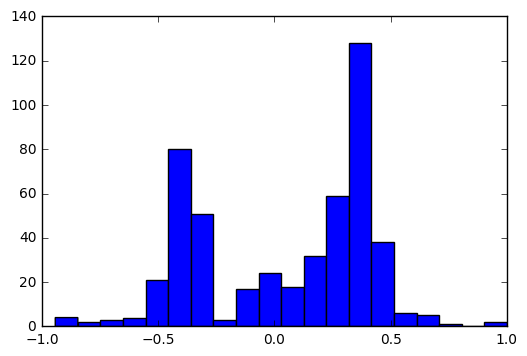

In [204]:
# examine data again
plt.hist(y_train_crop2,20)
plt.show()

In [205]:
# preprocess all data and save to pickle files
from PIL import Image
import pickle
    
def normalise(im):
    width,height = im.size
    im = np.array(im.resize((round(width*0.5),round(height*0.5)), Image.ANTIALIAS)) # reduce to half size
    im = im/255 - 0.5 # normalise data
    return im
        
def append_pickle (pickle_filename, data):
    with open(pickle_filename,'ab') as wfp:
        pickle.dump(data, wfp)

def process_images (data, pickle_filename):
    X_train_im = []
    for filename in data:
        #print('data/data/'+filename)
        im = Image.open('data/data/'+filename)
        #plt.imshow(im);
        #plt.show()
        im = normalise(im)
        X_train_im.append(im)
    return X_train_im
        #append_pickle(pickle_filename, im)
    #print('Data saved to pickle file:',pickle_filename)
    
def process_labels (data, pickle_filename):
    append_pickle(pickle_filename, data)
    print('Data saved to pickle file:',pickle_filename)

X_train_im = process_images (X_train_crop2,'data.p') # note: here images are saved one by one
#process_labels (y_train[1:6],'labels.p') # note: labels are saved all in one go
print ('Images processed and stored in array')

Images processed and stored in array


In [206]:
from numpy import *
print(type(X_train_im))
X_train_im = np.array(X_train_im)
X_train_im =X_train_im.astype(float32)
print(type(X_train_im))
print(type(y_train_crop))
y_train_crop2 = np.array(y_train_crop2)
y_train_crop2 = y_train_crop2.astype(float32)
print(type(y_train_crop))

<class 'list'>
<class 'numpy.ndarray'>
<class 'list'>
<class 'list'>


In [209]:
#save data to pickle files
pickle_filename = 'data.p'
with open(pickle_filename,'wb') as wfp:
    pickle.dump(X_train_im, wfp)
print('data saved to pickle file')
pickle_filename = 'labels.p'
with open(pickle_filename,'wb') as wfp:
    pickle.dump(y_train_crop2, wfp)
print('labels saved to pickle file')

data saved to pickle file
labels saved to pickle file


In [210]:
import pickle
# read data from pickle files

with open('data.p','rb') as rfp:
    data = pickle.load(rfp)
y_train = []
with open('labels.p','rb') as rfp:
    labels = pickle.load(rfp)
print(len(data))
print(len(labels))

498
498


In [211]:
from sklearn.model_selection import train_test_split

# split data into train, validate and test data
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2)
print(X_train.shape[0])
print('Data splitted into train and validation data')
print('Training data size = ', len(X_train))
print('Training labels size = ',len(y_train))
print('Validation data size = ',len(X_val))
print('Validation labels size = ',len(y_val))

398
Data splitted into train and validation data
Training data size =  398
Training labels size =  398
Validation data size =  100
Validation labels size =  100


In [212]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from keras.optimizers import Adam
# define the model
print('Input shape:',(X_train[0].shape))
height,width,depth = X_train[0].shape[0],X_train[0].shape[1],X_train[0].shape[2]
print('Input size:',height,',',width,',',depth)
model = Sequential()
#subsample=strides
model.add(Conv2D(24, 5, 5,subsample=(2, 2), input_shape=(X_train[0].shape), activation='relu'))
model.add(Conv2D(36, 5, 5,subsample=(2, 2), activation='relu'))
model.add(Conv2D(48, 5, 5,subsample=(2, 2), activation='relu'))
model.add(Conv2D(64, 3, 3,subsample=(1, 1), activation='relu'))
model.add(Conv2D(64, 3, 3,subsample=(1, 1), activation='relu'))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(100, name='fc1', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(50, name='fc2', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, name='fc3', activation='relu'))
model.add(Dense(1,name='output'))

# other layers we may add
#model.add(MaxPooling2D((2,2)))

# for a mean squared error regression problem
model.compile(optimizer=Adam(lr=0.0001),loss='mean_squared_error')
#model.compile(optimizer='rmsprop',loss='mse')
model.summary()
print('Model defined')

Input shape: (80, 160, 3)
Input size: 80 , 160 , 3
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_47 (Convolution2D) (None, 38, 78, 24)    1824        convolution2d_input_16[0][0]     
____________________________________________________________________________________________________
convolution2d_48 (Convolution2D) (None, 17, 37, 36)    21636       convolution2d_47[0][0]           
____________________________________________________________________________________________________
convolution2d_49 (Convolution2D) (None, 7, 17, 48)     43248       convolution2d_48[0][0]           
____________________________________________________________________________________________________
convolution2d_50 (Convolution2D) (None, 5, 15, 64)     27712       convolution2d_49[0][0]           
________________________________________

In [213]:
def next_batch(first_array, second_array, batch_size):
    index = np.random.choice(len(first_array), size=batch_size, replace=False)
    result_x = []
    result_y = []
    for id in index:
        result_x.append(first_array[id])
        result_y.append(second_array[id])
    return result_x, result_y

print('next_batch defined as a data generator')

next_batch defined as a data generator


In [214]:
def next_batch_val(first_array, second_array, batch_size):
    index = np.random.choice(len(first_array), size=batch_size, replace=False)
    result_x = []
    result_y = []
    for id in index:
        result_x.append(first_array[id])
        result_y.append(second_array[id])
    #result = (result_x, result_y)
    #yield result_x, result_y
    yield result_x, result_y

print('next_batch_val defined as a data generator')

next_batch_val defined as a data generator


In [215]:
#train the model
print('')
iterations = 50
train_batch_size = 200
val_batch_size = 200
history = model.fit(X_train, y_train, batch_size=train_batch_size, nb_epoch=iterations, verbose=1, validation_data=(X_val, y_val))
#history = model.fit_generator(next_batch(X_train,y_train,train_batch_size), samples_per_epoch=5000, nb_epoch=iterations,
  #                 verbose=1, validation_data=next_batch_val(X_val,y_val,val_batch_size), nb_val_samples=1000)
print('----------------- Model trained! -----------------')


Train on 398 samples, validate on 100 samples
Epoch 1/50
398/398 [==============================] - 2s - loss: 0.1462 - val_loss: 0.1223
Epoch 2/50
398/398 [==============================] - 1s - loss: 0.1461 - val_loss: 0.1221
Epoch 3/50
398/398 [==============================] - 1s - loss: 0.1460 - val_loss: 0.1219
Epoch 4/50
398/398 [==============================] - 1s - loss: 0.1459 - val_loss: 0.1216
Epoch 5/50
398/398 [==============================] - 1s - loss: 0.1458 - val_loss: 0.1214
Epoch 6/50
398/398 [==============================] - 1s - loss: 0.1455 - val_loss: 0.1211
Epoch 7/50
398/398 [==============================] - 1s - loss: 0.1454 - val_loss: 0.1207
Epoch 8/50
398/398 [==============================] - 1s - loss: 0.1450 - val_loss: 0.1202
Epoch 9/50
398/398 [==============================] - 1s - loss: 0.1448 - val_loss: 0.1196
Epoch 10/50
398/398 [==============================] - 1s - loss: 0.1444 - val_loss: 0.1188
Epoch 11/50
398/398 [=====================

In [216]:
# evaluate the model
scores = model.evaluate(X_val, y_val, verbose=0)
print(scores)

0.0504044955969


In [217]:
from keras.models import model_from_json

# convert model to json format
json_string = model.to_json()
with open('model.json', 'w') as outfile:
    json.dump(json_string, outfile)

#save model to files
model.save_weights('model.h5')

print('Model saved to file.')

Model saved to file.


In [80]:
from keras.models import load_model
# returns a compiled model
# identical to the previous one
model = load_model('model.h5')